In [2]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
from sklearn.ensemble import RandomForestClassifier



/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194714
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine_final", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine_final",
                                  version=1,
                                  description="Read from Wine Quality dataset",
                                  labels=["quality"],
                                  query=query)


Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/194714/fs/194633/fv/wine_final/version/1


In [6]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)



Finished: Reading data from Hopsworks, using ArrowFlight (0.84s) 


In [53]:
# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=1)  # You can adjust parameters here

# Train the classifier
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=1)

In [54]:
X_train

,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,alcohol
0,0.56,0.19,0.081,108.0,0.99620,9.5
1,0.62,0.19,0.170,148.0,0.99860,9.2
2,0.22,0.36,0.056,153.0,0.99300,10.4
3,0.20,0.17,0.048,129.0,0.99100,11.4
6,0.54,0.26,0.089,147.0,0.99636,9.7
...,...,...,...,...,...,...
5290,0.95,0.03,0.090,20.0,0.99590,9.6
5291,0.24,0.23,0.046,133.0,0.99080,11.4
5292,0.27,0.49,0.057,235.0,1.00240,8.6
5293,0.54,0.09,0.038,97.0,0.99022,12.2


In [55]:
y_train

,quality
0,0
1,0
2,1
3,1
6,0
...,...
5290,0
5291,1
5292,0
5293,1


In [56]:
X_test

,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,alcohol
4,0.46,0.18,0.034,98.0,0.98960,12.6
5,0.20,0.36,0.028,157.0,0.99380,10.6
23,0.22,0.42,0.052,87.0,0.99220,11.8
25,0.32,0.43,0.050,65.0,0.99346,10.7
32,0.60,0.22,0.080,105.0,0.99613,9.9
...,...,...,...,...,...,...
5263,0.19,0.40,0.056,110.0,0.99540,9.9
5266,0.39,0.22,0.036,113.0,0.99260,10.2
5270,0.23,0.33,0.048,176.0,0.99472,10.1
5274,0.42,0.34,0.040,108.0,0.99155,12.8


In [57]:
# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.61      0.65       392
           1       0.79      0.85      0.82       667

    accuracy                           0.76      1059
   macro avg       0.75      0.73      0.74      1059
weighted avg       0.76      0.76      0.76      1059



In [58]:
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred,output_dict=True)
results = confusion_matrix(y_test, y_pred)

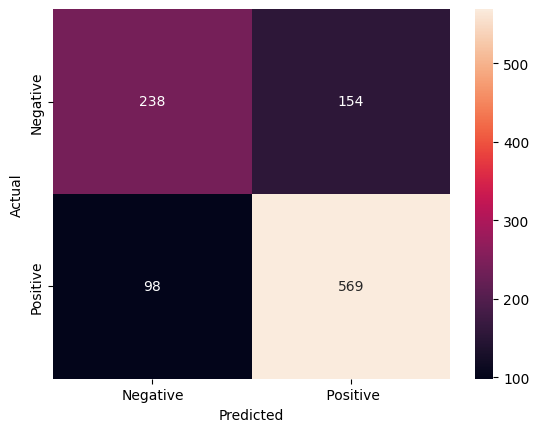

In [59]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results,["Negative", "Positive"],["Negative"," Positive"])
cm = sns.heatmap(df_cm, annot=True, fmt='d')
cm.set_xlabel('Predicted')
cm.set_ylabel('Actual')

fig = cm.get_figure()

In [60]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="wine_model_final", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)


Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 3988409/3988409 elapsed<00:03 remaining<00:003.59it/s]
Uploading: 100.000%|██████████| 18000/18000 elapsed<00:01 remaining<00:001,  3.59it/s]
Uploading: 100.000%|██████████| 629/629 elapsed<00:01 remaining<00:00<00:11,  2.86s/it]
Model export complete: 100%|██████████| 6/6 [00:12<00:00,  2.03s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/194714/models/wine_model_final/1


Model(name: 'wine_model_final', version: 1)